In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
wdir ="/content/drive/MyDrive/Raincoat"
os.chdir(wdir)

In [3]:
!pip install pytorch-metric-learning
!pip install skorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.6/118.6 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.3/239.3 kB 2.1 MB/s eta 0:00:00


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

from dataloader.dataloader import data_generator
from sklearn.metrics import f1_score, accuracy_score
from models.loss import SinkhornDistance
from pytorch_metric_learning import losses


#### Problem Statement

**Domain Adaptation**: Given the source and target domain time series datasets, $D^{S}$ and $D^{T}$, and target labels $y^t$ are not available at train time. Raincoats specifies a strategy to train a classifier $f$ on ${D}^S$ such that $f$ generalizes to ${D}^T$, i.e., it minimizes classification risk on ${D}^T$: ${E}_{x_i, y_i \sim {D}^T}\left[{C}(f(x_i), y_i)\right]$, where $C$ is a classification loss function.

##### We begin by defining configurations and loading source and target datasets

As a demonstration, we utilize the WISDM dataset, which comprises 3-axis accelerometer measurements acquired from 30 participants. The measurements were captured at a frequency of 20 Hz. Within the dataset, there are six distinct activity labels: walking, jogging, sitting, standing, walking upstairs, and walking downstairs.

In the context of domain adaptation, the participants themselves define the domains. For this particular example, we designate participant 2 as the source domain, from which we draw our training data, and participant 32 as the target domain, where our objective lies in generalizing the learned knowledge.

In [7]:
class WISDM_config():
     def __init__(self):
        super(WISDM_config, self)
        self.class_names = ['walk', 'jog', 'sit', 'stand', 'upstairs', 'downstairs']
        self.sequence_len = 128
        # Transfer scenarios, e.g., from source domain 2 to target domain 32
        self.scenarios = [("2", "32"), ("4", "15"),("7", "30"),('12','7'), ('12','19'),('18','20'),\
                          ('20','30'), ("21", "31"),("25", "29"), ('26','2')]

        self.num_classes = 6
        self.shuffle = True
        self.drop_last = False
        self.normalize = True

        # model configs
        self.input_channels = 3
        self.kernel_size = 5
        self.stride = 1
        self.dropout = 0.5
        self.num_classes = 6
        self.width = 64
        # for Fourier Frequency Feature Extration, number of modes to keep
        self.fourier_modes = 64
        # features
        self.mid_channels = 64
        self.final_out_channels = 128
        self.out_dim = self.final_out_channels+ self.fourier_modes * 2
        self.features_len = 1


In [8]:
# WISDM
data_path = 'data/WISDM'
src_id = '2'
trg_id = '32'
dataset_configs = WISDM_config()
hparams = {"batch_size":64, 'learning_rate':1e-3,'weight_decay': 1e-4,'num_epochs': 100}

src_train_dl, src_test_dl = data_generator(data_path, src_id,dataset_configs, hparams)
trg_train_dl, trg_test_dl = data_generator(data_path, trg_id, dataset_configs,hparams)

Visulize a time series sample

#### We begin by highlighting the significance of frequency features in DA for time series.

Domain adaptation revolves around the fundamental concept of extracting domain-invariant features between source and target domains. In this context, the accompanying figure showcases the sensor readings of walking activity from two distinct individuals (denoted as 4 and 15). The primary objective of domain adaptation methods is to train an encoder capable of projecting source and target domain features as closely aligned as feasible. To address the underlying time feature shift or discrepancy assumption, several methods have been proposed for achieving feature alignment. It is important to note that, for the sake of simplicity, only the first sensor reading is visualized in the provided illustration.

tensor(3) tensor(3)


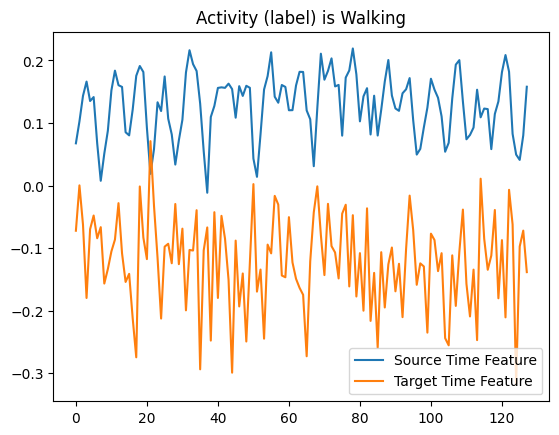

In [ ]:
#WISDM data
src_x, src_y = src_train_dl.dataset.x_data[2], src_train_dl.dataset.y_data[2]
trg_x, trg_y = trg_train_dl.dataset.x_data[1], trg_train_dl.dataset.y_data[1]
print(src_y, trg_y)
assert src_y == trg_y  # Ensure two selected samples have the same label
plt.plot(src_x.t()[:,0], label='Source Time Feature')
plt.plot(trg_x.t()[:,0], label='Target Time Feature')
plt.title(f'Activity (label) is Walking')
plt.legend()
plt.show()

##### Frequency Features Promote Domain Adaptation
Researchers demonstrated that the performance of DA techniques is bounded by the divergence between the source and target domains, and that a small feature shift is necessary for DA techniques to be effective. However, unsupervised DA methods for time series align only time features, leading to sub-optimal performance when the time feature shift is large.

By including frequency features in the encoder, we can uncover potential invariant features across domains and improve transferability. The accompanying figure showcases the frequency features of walking activity from two distinct individuals (denoted as 4 and 15) in the polar coordinates. As shown in the figure below, frequency features from different domains do not exhibit significant feature shifts and thus are domain invariant. This suggests that incorporating frequency features can lead to more accurate predictions in the target domain as DA aims to extract domain-invariant features.For this reason, Raincoat uses both time and frequency features in domain alignment.

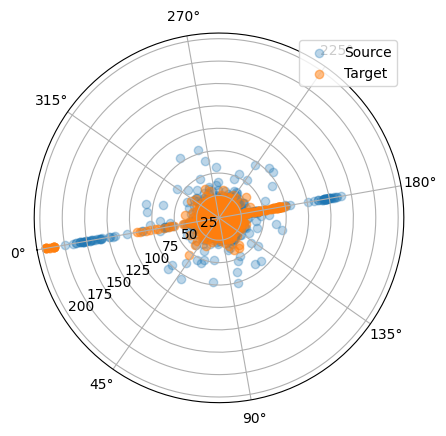

In [ ]:
# WISDM dataset
src_x = src_train_dl.dataset.x_data
trg_x = trg_train_dl.dataset.x_data
# Extract frequency features for the source domain
x_ft_src = torch.fft.rfft(src_x)
r_src = x_ft_src[:,0,:32].abs()
p_src = x_ft_src[:,0,:32].angle()
# Extract frequency features for the target domain
x_ft_trg = torch.fft.rfft(trg_x)
r_trg = x_ft_trg[:,0,:32].abs()
p_trg = x_ft_trg[:,0,:32].angle()

fig = plt.figure()
ax = fig.add_subplot(projection='polar')
c = ax.scatter(p_src, r_src, alpha=0.3, label='Source')
c = ax.scatter(p_trg, r_trg, alpha=0.5, label='Target')


ax.set_theta_zero_location('W', offset=10)
ax.legend(loc='best')
plt.show()

#### Frequency Feature Extractor:

In Raincoat, we develop a frequency feature extractor based on Fourier Transform.
Given a time series $x_i$, the frequency feature encoder, defined as SpectralConv1D bewlo, extracts both amplitutde $r$ and phase $p$ feature by performing a parameterized convolutional.

We summarize how it encodes time-frequency feature from $x_i$. Define a convolution operator ``$\ast$" and weight matrix $\mathbf{B}$, the encoder encodes frequency features $e_{Freq,i}$ by:

1. Smooth: $x_i =\operatorname{Smooth}(x_i)$
2. DFT: $v_i =\operatorname{DFT}(x_i)$
3. Convolution: $\tilde{v}_{i}= \mathbf{B} \ast v_i$
4. Transform: $r_i, p_i \leftarrow \tilde{v}_{i} $
5. Extract: $ e_{Freq, i} = [r_i;p_i] $

In [9]:

class classifier(nn.Module):
    def __init__(self, configs):
        super(classifier, self).__init__()
        model_output_dim = configs.out_dim
        self.logits = nn.Linear(model_output_dim, configs.num_classes, bias=False)
        self.tmp= 0.1

    def forward(self, x):
        predictions = self.logits(x)/self.tmp
        return predictions

class SpectralConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, fl=128):
        super(SpectralConv1d, self).__init__()

        """
        1D Fourier layer. It does FFT, linear transform, and Inverse FFT.
        """
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1  #Number of Fourier modes to multiply, at most floor(N/2) + 1

        self.scale = (1 / (in_channels*out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, dtype=torch.cfloat))
        self.pi = torch.acos(torch.zeros(1)).item() * 2

    # Complex multiplication
    def compl_mul1d(self, input, weights):
        # (batch, in_channel, x ), (in_channel, out_channel, x) -> (batch, out_channel, x)
        return torch.einsum("bix,iox->box", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x = torch.cos(x)
        x_ft = torch.fft.rfft(x,norm='ortho')
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-1)//2 + 1,  device=x.device, dtype=torch.cfloat)
        out_ft[:, :, :self.modes1] = self.compl_mul1d(x_ft[:, :, :self.modes1], self.weights1)
        r = out_ft[:, :, :self.modes1].abs()
        p = out_ft[:, :, :self.modes1].angle()
        return torch.concat([r,p],-1), out_ft


#### TIme Feature Extactor:

Regarding the time feature extraction, we adopt the Convolutional Neural Network from AdaTime.

It consists of two layers of convolution blocks. Each block performs Convolution 1d BatchNorm, ReLu, Maxpool and Dropout sequentially.

In [10]:
class CNN(nn.Module):
    def __init__(self, configs):
        super(CNN, self).__init__()
        self.width = configs.input_channels
        self.channel = configs.input_channels
        self.fl =   configs.sequence_len
        self.fc0 = nn.Linear(self.channel, self.width) # input channel is 2: (a(x), x)
        self.conv_block1 = nn.Sequential(
            nn.Conv1d(configs.input_channels, configs.mid_channels, kernel_size=configs.kernel_size,
                      stride=configs.stride, bias=False, padding=(configs.kernel_size // 2)),
            nn.BatchNorm1d(configs.mid_channels),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2, padding=1),
            nn.Dropout(configs.dropout)
        )

        self.conv_block2 = nn.Sequential(
            nn.Conv1d(configs.mid_channels, configs.mid_channels , kernel_size=8, stride=1, bias=False, padding=4),
            nn.BatchNorm1d(configs.mid_channels),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2, padding=1)
        )

        self.conv_block3 = nn.Sequential(
            nn.Conv1d(configs.mid_channels , configs.final_out_channels, kernel_size=8, stride=1, bias=False,
                      padding=4),
            nn.BatchNorm1d(configs.final_out_channels),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2, padding=1),
        )
        self.adaptive_pool = nn.AdaptiveAvgPool1d(configs.features_len)


    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block3(x)
        x = self.adaptive_pool(x)
        x_flat = x.reshape(x.shape[0], -1)
        return x_flat

In [11]:
class Algorithm(torch.nn.Module):
    """
    A subclass of Algorithm implements a domain adaptation algorithm.
    Subclasses should implement the update() method.
    """

    def __init__(self, configs):
        super(Algorithm, self).__init__()
        self.configs = configs
        self.cross_entropy = nn.CrossEntropyLoss()

    def update(self, *args, **kwargs):
        raise NotImplementedError


#### The algorithm of Raincoat:

Raincoat consists of two essential steps, namely alignment and correction, which involve three modules:

1. The time-frequency encoder $G_{Time, Freq}$ plays a crucial role in the alignment step. It concatenates the outputs from two modules, namely Spectral1d (frequency feature encoder) and CNN (time feature encoder).

2. The classifier $H$ is responsible for making predictions and is defined above Spectral1d.

3. The auxiliary decoder $U_{Time, Freq}$, referred to as tf_decoder, is defined below.

During the initial alignment step, Raincoat trains a classifier $H$ using the labeled source dataset $D^S$. Additionally, it utilizes the feature encoder $G_{Time, Freq}$ and decoder $U_{Time, Freq}$, incorporating both $D^S$ and $D^T$. Simultaneously, it aligns the target features $z^t_i$ with the source features $z^s_i$ by leveraging Sinkhorn divergence. The overall loss function in this step consists of three terms.

1. The sinkhorn distance $L_{A}(z^t_i, z^s_i)$ encourages alignment between the target features $z^t_i$ and the source features $z^s_i$.

2. The reconstruction loss $L_R(x^s_i, U_{Time, Freq}(G_{Time, Freq}(x^s_i)))" promotes the learning of semantic features from the labeled source dataset $D^S$.

3. The classification loss $L_C(H(G_{Time, Freq}(x^s_i)), y^s_i)$ guides the model in correctly classifying the samples.

To summarize, the loss in this alignment step is defined as $L = \lambda_1 L_A + \lambda_2 L_R + \lambda_3 L_C$ and is specified in the Raincoat.update() function.

In addition to the alignment step, Raincoat incorporates a correction step to address potential negative transfer, particularly for target unknown samples. This step involves exploiting target-specific discriminative features by minimizing $L_R(x^t_i, U_{Time, Freq}(G_{Time, Freq}(x^t_i)))$. The implementation of this correction step can be found in the Raincoat.correct() function.


In [12]:
class tf_encoder(nn.Module):
    def __init__(self, configs):
        super(tf_encoder, self).__init__()
        self.modes1 = configs.fourier_modes   # Number of low-frequency modes to keep
        self.width = configs.input_channels
        self.length =  configs.sequence_len
        self.freq_feature = SpectralConv1d(self.width, self.width, self.modes1,self.length)  # Frequency Feature Encoder
        self.bn_freq = nn.BatchNorm1d(configs.fourier_modes*2)   # It doubles because frequency features contain both amplitude and phase
        self.cnn = CNN(configs).to('cuda')  # Time Feature Encoder
        self.avg = nn.Conv1d(self.width, 1, kernel_size=3 ,
                  stride=configs.stride, bias=False, padding=(3 // 2))


    def forward(self, x):
        ef, out_ft = self.freq_feature(x)
        ef = F.relu(self.bn_freq(self.avg(ef).squeeze()))
        et = self.cnn(x)
        f = torch.concat([ef,et],-1)
        return F.normalize(f), out_ft

class tf_decoder(nn.Module):
    def __init__(self, configs):
        super(tf_decoder, self).__init__()
        self.input_channels, self.sequence_len = configs.input_channels, configs.sequence_len
        self.bn1 = nn.BatchNorm1d(self.input_channels,self.sequence_len)
        self.bn2 = nn.BatchNorm1d(self.input_channels,self.sequence_len)
        self.convT = torch.nn.ConvTranspose1d(configs.final_out_channels, self.sequence_len, self.input_channels, stride=1)
        self.modes = configs.fourier_modes

    def forward(self, f, out_ft):
        x_low = self.bn1(torch.fft.irfft(out_ft, n=128))   # reconstruct  time series by using low frequency frequency features
        et = f[:,self.modes*2:]
        x_high = F.relu(self.bn2(self.convT(et.unsqueeze(2)).permute(0,2,1))) # reconstruct time series by using time features for high frequency patterns.
        return x_low + x_high

class RAINCOAT(Algorithm):
    def __init__(self, configs, hparams, device):
        super(RAINCOAT, self).__init__(configs)
        self.feature_extractor = tf_encoder(configs).to(device)
        self.decoder = tf_decoder(configs).to(device)
        self.classifier = classifier(configs).to(device)

        self.optimizer = torch.optim.Adam(
            list(self.feature_extractor.parameters()) + \
                list(self.decoder.parameters())+\
                list(self.classifier.parameters()),
            lr=hparams["learning_rate"],
            weight_decay=hparams["weight_decay"]
        )
        self.coptimizer = torch.optim.Adam(
            list(self.feature_extractor.parameters())+list(self.decoder.parameters()),
            lr=1*hparams["learning_rate"],
            weight_decay=hparams["weight_decay"]
        )

        self.hparams = hparams
        self.recons = nn.L1Loss(reduction='sum').to(device)
        self.pi = torch.acos(torch.zeros(1)).item() * 2
        self.loss_func = losses.ContrastiveLoss(pos_margin=0.5)
        self.sink = SinkhornDistance(eps=1e-3, max_iter=1000, reduction='sum')

    def update(self, src_x, src_y, trg_x):

        self.optimizer.zero_grad()
        # Encode both source and target features via our time-frequency feature encoder
        src_feat, out_s = self.feature_extractor(src_x)
        trg_feat, out_t = self.feature_extractor(trg_x)
        # Decode extracted features to time series
        src_recon = self.decoder(src_feat, out_s)
        trg_recon = self.decoder(trg_feat, out_t)
        # Compute reconstruction loss
        recons = 1e-4 * (self.recons(src_recon, src_x) + self.recons(trg_recon, trg_x))
        recons.backward(retain_graph=True)
        # Compute alignment loss
        dr, _, _ = self.sink(src_feat, trg_feat)
        sink_loss = dr
        sink_loss.backward(retain_graph=True)
        # Compute classification loss
        src_pred = self.classifier(src_feat)
        loss_cls = self.cross_entropy(src_pred, src_y)
        loss_cls.backward(retain_graph=True)
        self.optimizer.step()
        return {'Src_cls_loss': loss_cls.item(),'Sink': sink_loss.item()}

    def correct(self,src_x, src_y, trg_x):
        self.coptimizer.zero_grad()
        src_feat, out_s = self.feature_extractor(src_x)
        trg_feat, out_t = self.feature_extractor(trg_x)
        src_recon = self.decoder(src_feat, out_s)
        trg_recon = self.decoder(trg_feat, out_t)
        recons = 1e-4 * (self.recons(trg_recon, trg_x) + self.recons(src_recon, src_x))
        recons.backward()
        self.coptimizer.step()
        return {'recon': recons.item()}

In [13]:
def eval(algorithm, loader, final=False):
    device = 'cuda'
    feature_extractor = algorithm.feature_extractor.to(device)
    classifier = algorithm.classifier.to(device)
    if final == True:
        feature_extractor.load_state_dict(torch.load('backbone.pth'))
        classifier.load_state_dict(torch.load('classifier.pth'))
    feature_extractor.eval()
    classifier.eval()
    trg_pred_labels = np.array([])
    trg_true_labels = np.array([])
    with torch.no_grad():
        for data, labels in loader:
            data = data.float().to(device)
            labels = labels.view((-1)).long().to(device)
            features,_ = feature_extractor(data)
            predictions = classifier(features)

            pred = predictions.detach().argmax(dim=1)  # get the index of the max log-probability

            trg_pred_labels = np.append(trg_pred_labels, pred.cpu().numpy())
            trg_true_labels = np.append(trg_true_labels, labels.data.cpu().numpy())
    accuracy = accuracy_score(trg_true_labels, trg_pred_labels)
    f1 = f1_score(trg_pred_labels, trg_true_labels, pos_label=None, average="macro")
    return accuracy *100, f1

#### Training

In [14]:
scenarios = [("2", "32"), ("4", "15"),("7", "30"),('12','7'), ('12','19'),('18','20'),\
                          ('20','30'), ("21", "31"),("25", "29"), ('26','2')]

data_path = 'data/WISDM'
dataset_configs = WISDM_config()
hparams = {"batch_size":64, 'learning_rate':1e-3,'weight_decay': 1e-4,'num_epochs': 100}
device = 'cuda'
algorithm = RAINCOAT(dataset_configs, hparams,device)
algorithm.to(device)
best_f1 = 0
accu = []
for i in range(len(scenarios)):
  src_id = scenarios[i][0]
  trg_id = scenarios[i][1]

  src_train_dl, src_test_dl = data_generator(data_path, src_id,dataset_configs, hparams)
  trg_train_dl, trg_test_dl = data_generator(data_path, trg_id, dataset_configs,hparams)

  ### Alignment
  for i in range(hparams['num_epochs']):
      joint_loaders = enumerate(zip(src_train_dl, trg_train_dl))
      for step, ((src_x, src_y), (trg_x, _)) in joint_loaders:
          src_x, src_y, trg_x = src_x.float().to(device), src_y.long().to(device), \
                                  trg_x.float().to(device)
          loss = algorithm.update(src_x, src_y, trg_x)

      acc, f1 = eval(algorithm, src_train_dl)
      if f1>=best_f1:
          best_f1 = f1
          torch.save(algorithm.feature_extractor.state_dict(), 'backbone.pth')
          torch.save(algorithm.classifier.state_dict(), 'classifier.pth')
      if i %10==0:
          print(f'Epoch {i}: Validation Accuracy on Source Test is {acc}')

  tar_acc, tar_f1 = eval(algorithm, trg_test_dl,final=True)
  print(f'Target Accuracy before correction:{tar_acc}, Target F1:{tar_f1}')

  ### Correction
  for i in range(10):
      joint_loaders = enumerate(zip(src_train_dl, trg_train_dl))
      for step, ((src_x, src_y), (trg_x, _)) in joint_loaders:
          src_x, src_y, trg_x = src_x.float().to(device), src_y.long().to(device), \
                                  trg_x.float().to(device)
          loss = algorithm.correct(src_x, src_y, trg_x)

      acc, f1 = eval(algorithm, src_train_dl)
      if f1>=best_f1:
          best_f1 = f1
          torch.save(algorithm.feature_extractor.state_dict(), 'backbone.pth')
          torch.save(algorithm.classifier.state_dict(), 'classifier.pth')
      if i %10==0:
          print(f'Epoch {i}: Validation Accuracy on Source Test is {acc}')
  tar_acc, tar_f1 = eval(algorithm, trg_train_dl,final=True)
  accu.append(tar_acc)
  print(f'Target Accuracy after correction:{tar_acc}, Target F1:{tar_f1}')

Epoch 0: Validation Accuracy on Source Test is 27.34375
Epoch 10: Validation Accuracy on Source Test is 57.8125
Epoch 20: Validation Accuracy on Source Test is 69.53125
Epoch 30: Validation Accuracy on Source Test is 71.875
Epoch 40: Validation Accuracy on Source Test is 77.34375
Epoch 50: Validation Accuracy on Source Test is 78.125
Epoch 60: Validation Accuracy on Source Test is 89.0625
Epoch 70: Validation Accuracy on Source Test is 93.75
Epoch 80: Validation Accuracy on Source Test is 96.875
Epoch 90: Validation Accuracy on Source Test is 96.875
Target Accuracy before correction:79.71014492753623, Target F1:0.7103951117109012
Epoch 0: Validation Accuracy on Source Test is 100.0
Target Accuracy after correction:79.6875, Target F1:0.7056403635351004
Epoch 0: Validation Accuracy on Source Test is 71.875
Epoch 10: Validation Accuracy on Source Test is 89.0625
Epoch 20: Validation Accuracy on Source Test is 98.4375
Epoch 30: Validation Accuracy on Source Test is 100.0
Epoch 40: Validati

In [ ]:
accu

[71.875,
 82.8125,
 86.71875,
 89.0625,
 74.47916666666666,
 59.375,
 82.03125,
 39.0625,
 10.9375,
 67.96875]

In [ ]:
import pandas as pd
d = {"scenarios": scenarios, "accuracy": accu}
df_accuracy = pd.DataFrame(data=d)

In [ ]:
df_accuracy

,scenarios,accuracy
0,"(2, 32)",71.875000
1,"(4, 15)",82.812500
2,"(7, 30)",86.718750
3,"(12, 7)",89.062500
4,"(12, 19)",74.479167
5,"(18, 20)",59.375000
6,"(20, 30)",82.031250
7,"(21, 31)",39.062500
8,"(25, 29)",10.937500
9,"(26, 2)",67.968750


In [ ]:
df_accuracy.to_csv("accuracy_by_scenarios.csv")